# Análise da População

In [226]:
import pandas as pd
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt


### Funções:

In [227]:
def processar_ficheiro(caminho_ficheiro, header=4, pasta_saida='.'):
    nome_base = os.path.splitext(os.path.basename(caminho_ficheiro))[0]
    
    df = pd.read_excel(caminho_ficheiro, header=header)
    
    df.columns = df.columns.map(str).str.strip()

    if len(df.columns) >= 2:
        df.columns.values[0] = 'local'
        df.columns.values[1] = 'codigo'

    df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
    df = df[~df.iloc[:, 1:].isna().all(axis=1)]
    df = df.fillna(0)

    nome_base = os.path.splitext(os.path.basename(caminho_ficheiro))[0]
    caminho_csv = os.path.join(pasta_saida, f'{nome_base}.csv')
    df.to_csv(caminho_csv, index=False)

    return df


In [228]:
def carregar_municipios(df):
    df['codigo'] = df['codigo'].astype(str)
    df_municipios = df[df['codigo'].astype(str).apply(lambda x: len(x) >= 7)].copy()
    return df_municipios

In [229]:
def aplicar_kmeans(df, n_clusters=3, nome_cluster='cluster'):
    dados_numericos = df.drop(columns=['local', 'codigo'])
    scaler = StandardScaler()
    dados_escalados = scaler.fit_transform(dados_numericos)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(dados_escalados)

    # Ordena os clusters
    centroides = kmeans.cluster_centers_
    ordem = np.argsort(centroides[:, 0])
    novo_mapeamento = {old: new for new, old in enumerate(ordem)}
    labels_ordenados = np.vectorize(novo_mapeamento.get)(labels)

    df[nome_cluster] = labels_ordenados

    coluna = dados_numericos.columns[0]
    df_plot = df.copy()
    df_plot['valor'] = dados_escalados[:, 0]
    df_plot['y'] = 0 

    fig = px.scatter(
        df_plot, 
        x='valor', 
        y='y', 
        color=nome_cluster,
        hover_data=['local', 'codigo', coluna],
        color_continuous_scale='viridis',
    )
    fig.update_traces(marker=dict(size=10))
    fig.update_layout(
        xaxis_title=coluna,
        yaxis=dict(showticklabels=False, showgrid=False),
        height=300
    )
    fig.show()

    print(df[nome_cluster].value_counts().sort_index())
    return df



In [230]:
def elbow_rule(df, max_k=10):
    X = df.drop(columns=['local', 'codigo'])
    inertias = []
    ks = range(1, max_k + 1)

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(ks, inertias, marker='o')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inércia')
    plt.title('Regra do Cotovelo (Elbow Method)')
    plt.grid(True)
    plt.xticks(ks)
    plt.show()
def elbow_rule(df, max_k=10):
    X = df.drop(columns=['local', 'codigo'])
    inertias = []
    ks = range(1, max_k + 1)

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(ks, inertias, marker='o')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inércia')
    plt.title('Regra do Cotovelo (Elbow Method)')
    plt.grid(True)
    plt.xticks(ks)
    plt.show()

### Análise da densidade populacional

In [231]:
df_densidade_pop = processar_ficheiro('./Densidade Populacional.xls',0)
df_densidade_pop = carregar_municipios(df_densidade_pop)
aplicar_kmeans(df_densidade_pop,5,nome_cluster='cluster_densidade')


cluster_densidade
0    248
1     38
2     14
3      4
4      4
Name: count, dtype: int64


local   codigo  Densidade populacional  cluster_densidade
4    Arcos de Valdevez  1111601                    46.3                  0
5              Caminha  1111602                   118.7                  0
6              Melgaço  1111603                    32.0                  0
7               Monção  1111604                    84.8                  0
8     Paredes de Coura  1111605                    62.8                  0
..                 ...      ...                     ...                ...
339        Porto Santo  3003201                   125.6                  0
340      Ribeira Brava  3003107                   196.5                  0
341         Santa Cruz  3003108                   535.4                  1
342            Santana  3003109                    67.6                  0
343        São Vicente  3003110                    61.7                  0

[308 rows x 4 columns]

### Análise da Idade média da população residente

In [232]:
df_idade = processar_ficheiro('./Idade da população residente.xls',0)
df_idade = carregar_municipios(df_idade)
aplicar_kmeans(df_idade,4,nome_cluster='cluster_idade')

cluster_idade
0    115
1    105
2     61
3     27
Name: count, dtype: int64


local   codigo Idade da população residente  cluster_idade
5    Arcos de Valdevez  1111601                         33.1              2
6              Caminha  1111602                         30.5              1
7              Melgaço  1111603                         39.8              3
8               Monção  1111604                         33.4              2
9     Paredes de Coura  1111605                         31.5              2
..                 ...      ...                          ...            ...
343      Ribeira Brava  3003107                         25.5              0
344         Santa Cruz  3003108                         24.2              0
345            Santana  3003109                         31.1              2
346        São Vicente  3003110                         29.6              1
347        Porto Santo  3003201                         27.5              1

[308 rows x 4 columns]

In [233]:
df_indice_renovacao = processar_ficheiro('./Índice de renovação da população em idade ativa.xls',0)
df_indice_renovacao = carregar_municipios(df_indice_renovacao)
print(df_indice_renovacao.shape)

aplicar_kmeans(df_indice_renovacao,nome_cluster='cluster_indice_renovacao')

(308, 3)


cluster_indice_renovacao
0     80
1    125
2    103
Name: count, dtype: int64


local   codigo  \
4    Arcos de Valdevez  1111601   
5              Caminha  1111602   
6              Melgaço  1111603   
7               Monção  1111604   
8     Paredes de Coura  1111605   
..                 ...      ...   
339        Porto Santo  3003201   
340      Ribeira Brava  3003107   
341         Santa Cruz  3003108   
342            Santana  3003109   
343        São Vicente  3003110   

     Índice de renovação da população em idade ativa  cluster_indice_renovacao  
4                                               66.1                         1  
5                                               64.3                         1  
6                                               48.9                         0  
7                                               57.1                         0  
8                                               60.6                         0  
..                                               ...                       ...  
339                                             61.0                         0  
340                                             79.5                         2  
341                                             74.8                         1  
342                                             58.1                         0  
343                                             61.9                         1  

[308 rows x 4 columns]

# VER CÓDIGO ESTÁ MAL

In [234]:
df_pedido_residencia = processar_ficheiro('./População estrangeira que solicitou estatuto de residente.xls', 2).iloc[:, :8]
#df_indice_renovacao = carregar_municipios(df_pedido_residencia)
#print(df_pedido_residencia)

### Análise Saldo Migratório

In [235]:
df_saldo_migratorio = processar_ficheiro('./Saldo migratório.xls', 0)
df_saldo_migratorio = carregar_municipios(df_saldo_migratorio)
print(df_saldo_migratorio.shape)
aplicar_kmeans(df_saldo_migratorio,nome_cluster='cluster_saldo_migratorio')

(308, 3)


cluster_saldo_migratorio
0    276
1     30
2      2
Name: count, dtype: int64


local   codigo  Saldo migratório  cluster_saldo_migratorio
4    Arcos de Valdevez  1111601             403.0                         0
5              Caminha  1111602             332.0                         0
6              Melgaço  1111603             134.0                         0
7               Monção  1111604             310.0                         0
8     Paredes de Coura  1111605             115.0                         0
..                 ...      ...               ...                       ...
342      Ribeira Brava  3003107             292.0                         0
343         Santa Cruz  3003108             685.0                         0
344            Santana  3003109              82.0                         0
345        São Vicente  3003110             152.0                         0
346        Porto Santo  3003201             221.0                         0

[308 rows x 4 columns]

### Análise Saldo Natural

(308, 3)


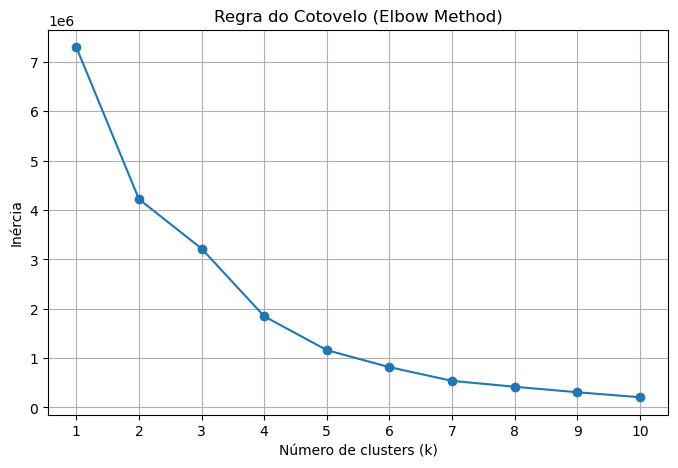

cluster_saldo_natural
0      9
1     84
2    215
Name: count, dtype: int64


local   codigo  Saldo natural  cluster_saldo_natural
4    Arcos de Valdevez  1111601         -296.0                      1
5              Caminha  1111602         -113.0                      2
6              Melgaço  1111603         -142.0                      1
7               Monção  1111604         -227.0                      1
8     Paredes de Coura  1111605          -79.0                      2
..                 ...      ...            ...                    ...
342      Ribeira Brava  3003107          -66.0                      2
343         Santa Cruz  3003108           -8.0                      2
344            Santana  3003109          -53.0                      2
345        São Vicente  3003110          -24.0                      2
346        Porto Santo  3003201           -9.0                      2

[308 rows x 4 columns]

In [236]:
df_saldo_natural= processar_ficheiro('./Saldo natural.xls', 0)
df_saldo_natural = carregar_municipios(df_saldo_natural)
print(df_saldo_natural.shape)

elbow_rule(df_saldo_natural, max_k=10)
aplicar_kmeans(df_saldo_natural,3,nome_cluster='cluster_saldo_natural')

### Análise Taxa de Crescimento

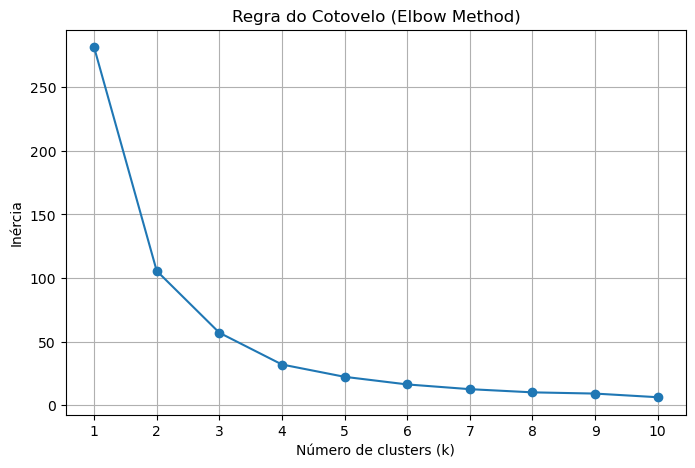

                 local   codigo  Taxa de crescimento efetivo
4    Arcos de Valdevez  1111601                         0.70
5              Caminha  1111602                         1.45
6              Melgaço  1111603                        -0.21
7               Monção  1111604                         0.65
8     Paredes de Coura  1111605                         0.38
..                 ...      ...                          ...
339        Porto Santo  3003201                         3.70
340      Ribeira Brava  3003107                         1.67
341         Santa Cruz  3003108                         1.47
342            Santana  3003109                         0.48
343        São Vicente  3003110                         2.13

[308 rows x 3 columns]


cluster_taxa_crescimento
0    56
1    97
2    77
3    58
4    20
Name: count, dtype: int64


local   codigo  Taxa de crescimento efetivo  \
4    Arcos de Valdevez  1111601                         0.70   
5              Caminha  1111602                         1.45   
6              Melgaço  1111603                        -0.21   
7               Monção  1111604                         0.65   
8     Paredes de Coura  1111605                         0.38   
..                 ...      ...                          ...   
339        Porto Santo  3003201                         3.70   
340      Ribeira Brava  3003107                         1.67   
341         Santa Cruz  3003108                         1.47   
342            Santana  3003109                         0.48   
343        São Vicente  3003110                         2.13   

     cluster_taxa_crescimento  
4                           1  
5                           3  
6                           0  
7                           1  
8                           1  
..                        ...  
339                         4  
340                         3  
341                         3  
342                         1  
343                         3  

[308 rows x 4 columns]

In [237]:
df_taxa_crescimento = processar_ficheiro('./Taxa de crescimento efetivo.xls', 0)
df_taxa_crescimento = carregar_municipios(df_taxa_crescimento)
elbow_rule(df_taxa_crescimento, max_k=10)

print(df_taxa_crescimento)
aplicar_kmeans(df_taxa_crescimento,5,nome_cluster='cluster_taxa_crescimento')



### Análise Global

In [ ]:
from functools import reduce
dataframes = [
    df_taxa_crescimento[['local', 'cluster_taxa_crescimento']],
    df_densidade_pop[['local', 'cluster_densidade']],
    df_idade[['local', 'cluster_idade']],
    df_saldo_natural[['local', 'cluster_saldo_natural']],
    df_saldo_migratorio[['local', 'cluster_saldo_migratorio']],
    df_indice_renovacao[['local', 'cluster_indice_renovacao']],
]

df_cluster_populacao = reduce(
    lambda left, right: pd.merge(left, right, on='local', how='inner'),
    dataframes
)


In [249]:
def kmeans_com_cotovelo(df, colunas_numericas, nome_cluster='cluster_final', max_k=10, k_escolhido=3):
    print(df.shape)
    df = df.copy()
    X = df[colunas_numericas].values
    X_scaled = StandardScaler().fit_transform(X)

    # Gráfico do cotovelo
    inercia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X_scaled)
        inercia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, max_k + 1), inercia, marker='o')
    plt.title('Método do Cotovelo')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inércia (Soma das Distâncias ao Centro)')
    plt.grid(True)
    plt.show()

    return df


(312, 7)


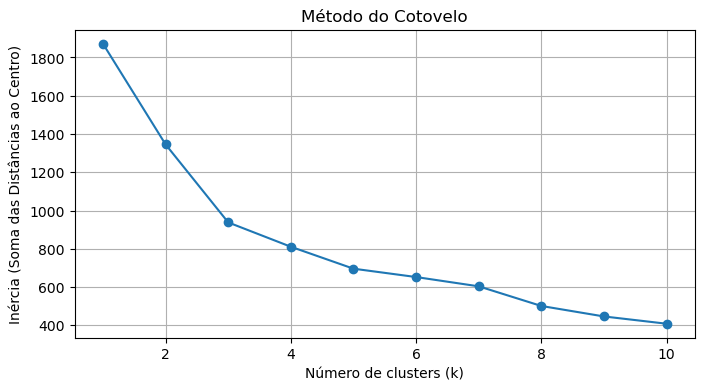

In [250]:
colunas_cluster = [
    'cluster_taxa_crescimento',
    'cluster_densidade',
    'cluster_idade',
    'cluster_saldo_natural',
    'cluster_saldo_migratorio',
    'cluster_indice_renovacao'
]

df_resultado = kmeans_com_cotovelo(df_cluster_populacao, colunas_numericas=colunas_cluster, k_escolhido=3)


In [251]:
X = df_cluster_populacao[colunas_cluster].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=6, random_state=42, n_init='auto')
df_cluster_populacao['cluster_final'] = kmeans.fit_predict(X_scaled)


print(df_cluster_populacao['cluster_final'].value_counts().sort_index())


cluster_final
0    81
1    23
2    62
3    22
4    72
5    52
Name: count, dtype: int64
